## Predicting Water Quality of Sydney's Northern Beaches 

Last season, La Nina's unusually regular rainfall caused havoc with Sydney Beaches water quality. Pollution warnings from NSW department of environments' Beachwatch website seemed relatively conservative, if not completely innaccurate.

Water quality is a serious issue, and causes many people to get sick. There were anecdotal reports last year amoungst the surf community that a local manly school saw many of the kids fall ill following a nippers event at queenscliff where the water quality was low. 

For many, surfing and getting in the ocean is a way of life. There is always a risk getting in the water, which tends to make people discount the risk that they may be taking, and often dismiss warnings, whether they be big surf warnings, shark warnings, or water quality warnings. 

Reading Beachwatch's website they report that water quality testing takes 2-3 days to return, hence they forecast quality using 5 years of baterial data to determine 'rainfall thresholds' for each swimming location (The rainfall threshold is the amount of rain that falls before the number of bacteria in the water reaches a level that means the water is polluted).

This seems like a relatively simple model, and my own experience surfing had led me to question and discount the forecast. Relying instead on my own observations (which tend to be made once I am out behind the waves and sound something like "welp, don't put your head under - this water is gross")

##### Historical note

In the late 80's the water quality of Sydney beaches was a major issue of interest for the general pulic. This resulted in sewers which previously ended on the coast line - spewing sewage and industrial waste onto nearby beaches and swimming locations - being extended out further from the shore. These are called deep water outfalls. 

For the most part this has resolved much of the pollution issue, however in the design of the outfalls, there is an issue, where should the sewer get too much going through it (which tends to happen during heavy rainfall), it flows into the rain water system, and into rainfall outfalls which usually go straight into creek systems, and through pipes visable throughout the northern beaches - notably, Freashwater, Manly and Collaroys stormwater drain, which is a hazard at the best of times,claiming the lives of surfers over the years, most recently in August 2020.

##
table with what the cfu levels mean.
https://www.environment.nsw.gov.au/topics/water/beaches/reporting-beach-water-quality/guidelines/microbial-assessments 

## Model

Bacteria_levels ~ 

(rainfall_24hr + rainfall_48hr + rainfall_72hr, + rainfall_96hr + rainfall_120hrs)*locations

UV level (including lagging)

water temperature

salinity or PH of the ocean

Ocean Current Or Swell

Tide height at time of measurement

wind stregnth + wind direction 

sydney population 

levels of sewage processed

location (is this is multilevel model)?

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np

import os
from fnmatch import fnmatch

from datetime import datetime


%matplotlib inline

In [3]:
#read in cfu dataset sourced from: https://www.environment.nsw.gov.au/beachapp/report_enterococci.aspx
df_cfu = pd.read_csv('data/EnterococciDataDownload-20221023-093957.csv')

In [4]:
df_cfu.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50112 entries, 0 to 50111
Data columns (total 8 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   BeachId                  50112 non-null  float64
 1   Region                   50112 non-null  object 
 2   Council                  50112 non-null  object 
 3   Site                     50112 non-null  object 
 4   Longitude                50112 non-null  float64
 5   Latitude                 50112 non-null  float64
 6   Date                     50112 non-null  object 
 7   Enterococci (cfu/100ml)  40124 non-null  float64
dtypes: float64(4), object(4)
memory usage: 3.1+ MB


In [5]:
df_cfu.rename({"Enterococci (cfu/100ml)":"cfu_per_100ml_Enterococci"}, inplace = True, axis = 1)

In [6]:
#drop region, beach ID, council.

df_cfu.drop(['Region', 'BeachId', 'Council'], axis = 1, inplace= True)


In [7]:
#there are some missing values for Enterococci - 
# These are in earlier years before testing protocols were established. 
#We can drop this safely. 
print((df_cfu.isnull().sum()))


Site                            0
Longitude                       0
Latitude                        0
Date                            0
cfu_per_100ml_Enterococci    9988
dtype: int64


In [8]:
#drop na's - aka missing measurements 

df_cfu.dropna(inplace= True)

<AxesSubplot: title={'center': 'cfu_per_100ml_Enterococci'}, xlabel='[Site]'>

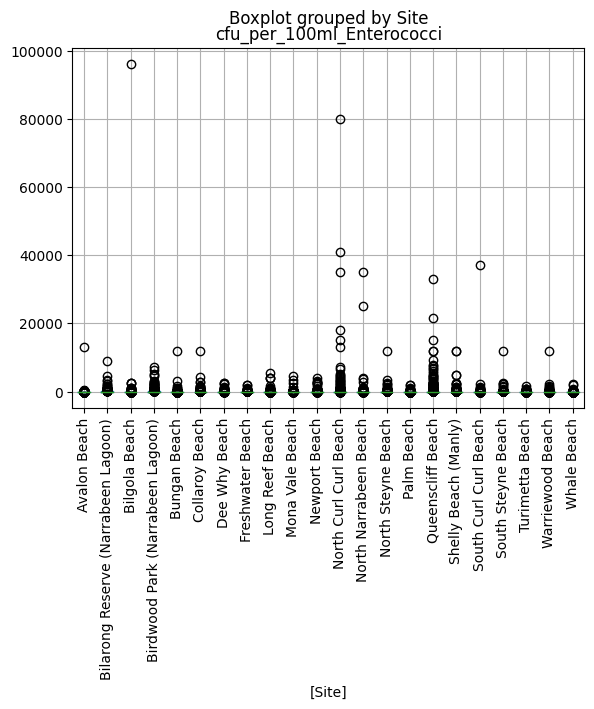

In [9]:
#from this graph, we can see the distribution is almost always zero, and truly defined by the outliers.
df_cfu[['Site', 'cfu_per_100ml_Enterococci']].boxplot(by = 'Site', rot = 90)


<AxesSubplot: title={'center': 'cfu_per_100ml_Enterococci'}, xlabel='[Site]'>

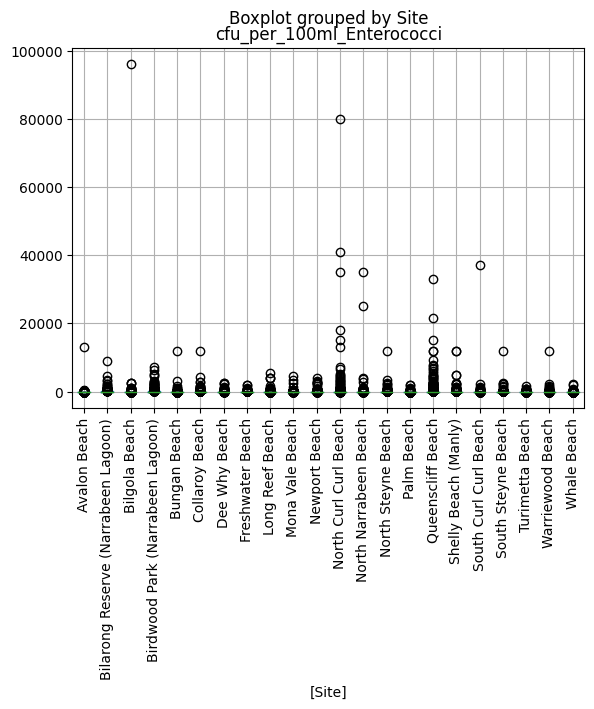

In [10]:
#zooming into the bottom of the matrix.
df_cfu[['Site', 'cfu_per_100ml_Enterococci']].boxplot(by = 'Site', rot = 90, )


In [11]:
# sns.lineplot(x='Date',
#     y='cfu_per_100ml_Enterococci',
#     hue='Site',
#     data=df_cfu) 


In [12]:
#import rainfall data 

df_rainfall = pd.DataFrame()

root = '/Users/samwakeling/python/GADS/Sam/Capstone_Water_Quality_Predictions/data/rainfall'
pattern = "*.csv"

for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            #print(path.split("/")[9].split("_")[0])
            #print(os.path.join(path))
            df_temp = pd.read_csv(os.path.join(path, name)) #read in csv
            df_temp['location'] = path.split("/")[9].split("_")[0] #add location column
            df_rainfall = pd.concat([df_rainfall, df_temp], ignore_index=True) #join to master rainfall df. 
        



In [13]:
df_rainfall['location'] = df_rainfall['location'] + '_rainfall'

In [14]:
df_rainfall.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159323 entries, 0 to 159322
Data columns (total 9 columns):
 #   Column                                          Non-Null Count   Dtype  
---  ------                                          --------------   -----  
 0   Product code                                    159323 non-null  object 
 1   Bureau of Meteorology station number            159323 non-null  int64  
 2   Year                                            159323 non-null  int64  
 3   Month                                           159323 non-null  int64  
 4   Day                                             159323 non-null  int64  
 5   Rainfall amount (millimetres)                   123527 non-null  float64
 6   Period over which rainfall was measured (days)  55203 non-null   float64
 7   Quality                                         123522 non-null  object 
 8   location                                        159323 non-null  object 
dtypes: float64(2), int64(4), ob

In [15]:
df_rainfall.dropna(subset='Rainfall amount (millimetres)', inplace = True)

In [16]:
df_rainfall['Date'] = df_rainfall[['Day', 'Month', 'Year']].apply(lambda x: '/'.join(x.values.astype(str)), axis="columns")

In [17]:
#strip spaces in names
#remove () in names
df_rainfall.columns = df_rainfall.columns.str.replace(' ', '')
df_rainfall.columns = df_rainfall.columns.str.replace(')', '')
df_rainfall.columns = df_rainfall.columns.str.replace('(', '_')


/var/folders/7w/yf69zr7x0z128p03t9lrhglc0000gn/T/ipykernel_29721/1099749899.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_rainfall.columns = df_rainfall.columns.str.replace(')', '')
/var/folders/7w/yf69zr7x0z128p03t9lrhglc0000gn/T/ipykernel_29721/1099749899.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_rainfall.columns = df_rainfall.columns.str.replace('(', '_')


In [18]:
df_rainfall.head()

,Productcode,BureauofMeteorologystationnumber,Year,Month,Day,Rainfallamount_millimetres,Periodoverwhichrainfallwasmeasured_days,Quality,location,Date
181,IDCJAC0009,66011,1951,7,1,0.0,NaN,Y,Chatswood_rainfall,1/7/1951
182,IDCJAC0009,66011,1951,7,2,0.0,NaN,Y,Chatswood_rainfall,2/7/1951
183,IDCJAC0009,66011,1951,7,3,0.0,NaN,Y,Chatswood_rainfall,3/7/1951
184,IDCJAC0009,66011,1951,7,4,0.0,NaN,Y,Chatswood_rainfall,4/7/1951
185,IDCJAC0009,66011,1951,7,5,0.0,NaN,Y,Chatswood_rainfall,5/7/1951


In [19]:
df_rainfall = df_rainfall.drop(['Productcode', 'BureauofMeteorologystationnumber', 'Year', 'Month', 'Day'],axis = 'columns')

In [20]:
df_rainfall.head()

,Rainfallamount_millimetres,Periodoverwhichrainfallwasmeasured_days,Quality,location,Date
181,0.0,NaN,Y,Chatswood_rainfall,1/7/1951
182,0.0,NaN,Y,Chatswood_rainfall,2/7/1951
183,0.0,NaN,Y,Chatswood_rainfall,3/7/1951
184,0.0,NaN,Y,Chatswood_rainfall,4/7/1951
185,0.0,NaN,Y,Chatswood_rainfall,5/7/1951


In [21]:
#todo fix NAN
df_rainfall['Periodoverwhichrainfallwasmeasured_days'] = df_rainfall['Periodoverwhichrainfallwasmeasured_days'].fillna(0)
df_rainfall = df_rainfall[df_rainfall['Periodoverwhichrainfallwasmeasured_days'] == 1]

In [22]:
df_rainfall['Date'] = pd.to_datetime(df_rainfall['Date']).dt.date

/var/folders/7w/yf69zr7x0z128p03t9lrhglc0000gn/T/ipykernel_29721/4239145316.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_rainfall['Date'] = pd.to_datetime(df_rainfall['Date']).dt.date


In [23]:
df_rainfall_pivot = df_rainfall.pivot(index = 'Date', columns = 'location', values = 'Rainfallamount_millimetres')

In [24]:
df_rainfall_pivot.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15906 entries, 1951-01-08 to 2022-12-10
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Avalon_rainfall        5241 non-null   float64
 1   Belrose_rainfall       5321 non-null   float64
 2   CastleCove_rainfall    7297 non-null   float64
 3   Chatswood_rainfall     9125 non-null   float64
 4   Collaroy_rainfall      4162 non-null   float64
 5   DoverHeights_rainfall  2182 non-null   float64
 6   MonaVale_rainfall      8468 non-null   float64
 7   Palm_rainfall          6569 non-null   float64
 8   TerryHills_rainfall    6359 non-null   float64
dtypes: float64(9)
memory usage: 1.2+ MB


In [25]:
#chatswood(2000), dover heights (2002) and terry hills (2004) observations started the latest. Dropping them to try and include more values. 
df_rainfall_pivot.drop(['TerryHills_rainfall', 'DoverHeights_rainfall', 'Chatswood_rainfall'], axis = 1, inplace = True)

In [26]:
#zero rainfall values are recorded as NAN, replace with zero. This does assume continuous collection, which is not the case, but good enough.
df_rainfall_pivot = df_rainfall_pivot.fillna(0)

In [27]:
#lags
for i in df_rainfall_pivot.columns:
    df_rainfall_pivot[i + '_1lag'] = df_rainfall_pivot[i].shift(1)
    df_rainfall_pivot[i + '_3lag'] = df_rainfall_pivot[i].rolling(window = 3).sum()

In [28]:
#df_rainfall_pivot['date'] = pd.to_datetime(df_rainfall_pivot.index)

In [29]:
#join to df_cfu
df_cfu['Date'] = pd.to_datetime(df_cfu['Date']).dt.date


/var/folders/7w/yf69zr7x0z128p03t9lrhglc0000gn/T/ipykernel_29721/2959519819.py:2: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_cfu['Date'] = pd.to_datetime(df_cfu['Date']).dt.date


In [30]:
df_master = df_cfu.merge(df_rainfall_pivot, on = 'Date', how = 'left')

In [31]:
#import port kembla ocean metrics 

df_ocean = pd.DataFrame()

root = '/Users/samwakeling/python/GADS/Sam/Capstone_Water_Quality_Predictions/data/ocean'
pattern = "*.csv"

for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            #print(path.split("/")[9].split("_")[0])
            #print(os.path.join(path, name))
            df_temp = pd.read_csv(os.path.join(path, name)) #read in csv
            #df_temp['location'] = path.split("/")[9].split("_")[0] #add location column
            df_ocean = pd.concat([df_ocean, df_temp], ignore_index=True) #join to master rainfall df. 
        

In [32]:
#fix col names
df_ocean.columns = df_ocean.columns.str.replace(' ', '')

df_ocean = df_ocean.replace('-9999', np.nan)

In [33]:
df_ocean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272472 entries, 0 to 272471
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Date&UTCTime        272472 non-null  object 
 1   SeaLevel            272472 non-null  float64
 2   WaterTemperature    272472 non-null  float64
 3   AirTemperature      272472 non-null  float64
 4   BarometricPressure  272472 non-null  float64
 5   Residuals           272472 non-null  float64
 6   AdjustedResiduals   272472 non-null  float64
 7   WindDirection       272472 non-null  int64  
 8   WindGust            272472 non-null  float64
 9   WindSpeed           272472 non-null  float64
 10  PortKembla          0 non-null       float64
dtypes: float64(9), int64(1), object(1)
memory usage: 22.9+ MB


In [34]:
df_ocean['Date'] = pd.to_datetime(df_ocean['Date&UTCTime']).dt.normalize()

In [35]:
from statistics import mode

df_ocean['ocean_temp_max'] = df_ocean.groupby('Date')['WaterTemperature'].transform('max')
df_ocean['ocean_temp_min'] = df_ocean.groupby('Date')['WaterTemperature'].transform('min')
df_ocean['ocean_temp_mode'] = df_ocean.groupby('Date')['WaterTemperature'].transform(mode)

df_ocean['air_temp_max'] = df_ocean.groupby('Date')['AirTemperature'].transform('max')
df_ocean['air_temp_min'] = df_ocean.groupby('Date')['AirTemperature'].transform('min')
df_ocean['air_temp_mode'] = df_ocean.groupby('Date')['AirTemperature'].transform(mode)

df_ocean['wind_speed_max'] = df_ocean.groupby('Date')['AirTemperature'].transform('max')
df_ocean['wind_speed_mean'] = df_ocean.groupby('Date')['AirTemperature'].transform('min')

df_ocean['sea_level_max'] = df_ocean.groupby('Date')['SeaLevel'].transform('max')
df_ocean['sea_level_mmi'] = df_ocean.groupby('Date')['SeaLevel'].transform('min')

df_ocean['barometric_pressure_max'] = df_ocean.groupby('Date')['BarometricPressure'].transform('max')
df_ocean['barometric_pressure_min'] = df_ocean.groupby('Date')['BarometricPressure'].transform('min')

df_ocean['wind_speed_mean'] = df_ocean.groupby('Date')['WindSpeed'].transform('mean')
df_ocean['wind_speed_min'] = df_ocean.groupby('Date')['WindSpeed'].transform('min')
df_ocean['wind_speed_max'] = df_ocean.groupby('Date')['WindSpeed'].transform('max')



In [36]:
#convert to cardinal from angle for wind direction. 
direction_cat = pd.read_csv('/Users/samwakeling/python/GADS/Sam/Capstone_Water_Quality_Predictions/data/wind_direction_cat.csv')

df_ocean['WindDirection_cat'] = pd.cut(x=df_ocean['WindDirection'], bins = direction_cat['degree_min'], labels= direction_cat['cardinal'][0:17], ordered=False)



In [37]:
df_ocean['WindDirection_cat'] = df_ocean.groupby('Date')['WindDirection_cat'].transform(mode)


In [38]:
df_ocean = df_ocean.iloc[0:272472,11:26].drop_duplicates()

In [39]:
df_ocean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11353 entries, 0 to 272448
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Date                     11353 non-null  datetime64[ns]
 1   ocean_temp_max           11353 non-null  float64       
 2   ocean_temp_min           11353 non-null  float64       
 3   ocean_temp_mode          11353 non-null  float64       
 4   air_temp_max             11353 non-null  float64       
 5   air_temp_min             11353 non-null  float64       
 6   air_temp_mode            11353 non-null  float64       
 7   wind_speed_max           11353 non-null  float64       
 8   wind_speed_mean          11353 non-null  float64       
 9   sea_level_max            11353 non-null  float64       
 10  sea_level_mmi            11353 non-null  float64       
 11  barometric_pressure_max  11353 non-null  float64       
 12  barometric_pressure_min  11353 

In [40]:
df_master['Date'] = pd.to_datetime(df_master['Date'])

In [41]:
df_master = df_master.merge(df_ocean, on = 'Date', how = 'left')

In [42]:
#bring in sun values

#import rainfall data 

df_sun = pd.DataFrame()

root = '/Users/samwakeling/python/GADS/Sam/Capstone_Water_Quality_Predictions/data/sun'
pattern = "*.csv"

for path, subdirs, files in os.walk(root):
    for name in files:
        if fnmatch(name, pattern):
            #print(path.split("/")[9].split("_")[0])
            #print(os.path.join(path, name))
            df_temp = pd.read_csv(os.path.join(path, name)) #read in csv
            df_temp['location'] = path.split("/")[9].split("_")[0]#add location column
            df_sun = pd.concat([df_sun, df_temp], ignore_index=True) #join to master rainfall df. 
        




In [43]:
df_sun['location'] = df_sun['location'] + '_solar_ex'

In [44]:
df_sun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59920 entries, 0 to 59919
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Product code                          59920 non-null  object 
 1   Bureau of Meteorology station number  59920 non-null  int64  
 2   Year                                  59920 non-null  int64  
 3   Month                                 59920 non-null  int64  
 4   Day                                   59920 non-null  int64  
 5   Daily global solar exposure (MJ/m*m)  57514 non-null  float64
 6   location                              59920 non-null  object 
dtypes: float64(1), int64(4), object(2)
memory usage: 3.2+ MB


In [45]:
#strip spaces in names
#remove () in names
df_sun.columns = df_sun.columns.str.replace(' ', '')
df_sun.columns = df_sun.columns.str.replace(')', '')
df_sun.columns = df_sun.columns.str.replace('(', '_')

/var/folders/7w/yf69zr7x0z128p03t9lrhglc0000gn/T/ipykernel_29721/473928805.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_sun.columns = df_sun.columns.str.replace(')', '')
/var/folders/7w/yf69zr7x0z128p03t9lrhglc0000gn/T/ipykernel_29721/473928805.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df_sun.columns = df_sun.columns.str.replace('(', '_')


In [46]:
df_sun.rename(columns = {'Dailyglobalsolarexposure_MJ/m*m' : 'solar_ex'}, inplace = True)

In [47]:
df_sun.dropna(subset='solar_ex', inplace = True)
df_sun['Date'] = df_sun[['Day', 'Month', 'Year']].apply(lambda x: '/'.join(x.values.astype(str)), axis="columns")


In [48]:
df_sun = df_sun.drop(['Productcode', 'BureauofMeteorologystationnumber', 'Year', 'Month', 'Day'],axis = 'columns')

In [49]:
df_sun.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 57514 entries, 0 to 59919
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   solar_ex  57514 non-null  float64
 1   location  57514 non-null  object 
 2   Date      57514 non-null  object 
dtypes: float64(1), object(2)
memory usage: 1.8+ MB


In [50]:
df_sun['Date'] = pd.to_datetime(df_sun['Date'])

/var/folders/7w/yf69zr7x0z128p03t9lrhglc0000gn/T/ipykernel_29721/3688989146.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_sun['Date'] = pd.to_datetime(df_sun['Date'])


In [51]:
df_sun_pivot = df_sun.pivot(index = 'Date', columns = 'location', values = 'solar_ex')

In [52]:
df_master = df_master.merge(df_sun_pivot, on = 'Date', how = 'left')

Exploratory Data Analysis

I end up with 1500 observations each beach, which is about 5 years of data across 22 beaches/locations, a total of 33,556 observations. 

In [53]:
df_master_naless = df_master.dropna()

In [54]:
df_master_naless['Site'].value_counts()

Queenscliff Beach                      1704
South Steyne Beach                     1688
North Steyne Beach                     1659
Shelly Beach (Manly)                   1655
North Curl Curl Beach                  1646
Whale Beach                            1600
Newport Beach                          1599
Dee Why Beach                          1597
Collaroy Beach                         1597
Warriewood Beach                       1597
Bungan Beach                           1596
Bilgola Beach                          1596
North Narrabeen Beach                  1595
Palm Beach                             1592
Avalon Beach                           1591
Mona Vale Beach                        1590
Freshwater Beach                       1586
South Curl Curl Beach                  1585
Long Reef Beach                        1576
Turimetta Beach                        1455
Birdwood Park (Narrabeen Lagoon)        976
Bilarong Reserve (Narrabeen Lagoon)     476
Name: Site, dtype: int64

In [55]:
df_master_naless.cfu_per_100ml_Enterococci.value_counts()

0.0      11745
2.0       3365
1.0       2792
4.0       1890
6.0       1279
         ...  
194.0        1
186.0        1
456.0        1
392.0        1
149.0        1
Name: cfu_per_100ml_Enterococci, Length: 321, dtype: int64

In [56]:
a = df_master_naless['Date'].value_counts()
a

2022-02-15    22
2017-01-23    22
2017-08-06    22
2017-04-28    22
2017-10-17    22
              ..
1995-07-02     3
1995-08-01     3
1995-01-14     3
1996-01-29     1
1992-09-19     1
Name: Date, Length: 1734, dtype: int64

### Correlation plot

/var/folders/7w/yf69zr7x0z128p03t9lrhglc0000gn/T/ipykernel_29721/795717774.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean_corr = df_master_naless.iloc[:,5:63].corr()
/var/folders/7w/yf69zr7x0z128p03t9lrhglc0000gn/T/ipykernel_29721/795717774.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(mean_corr, dtype=np.bool)


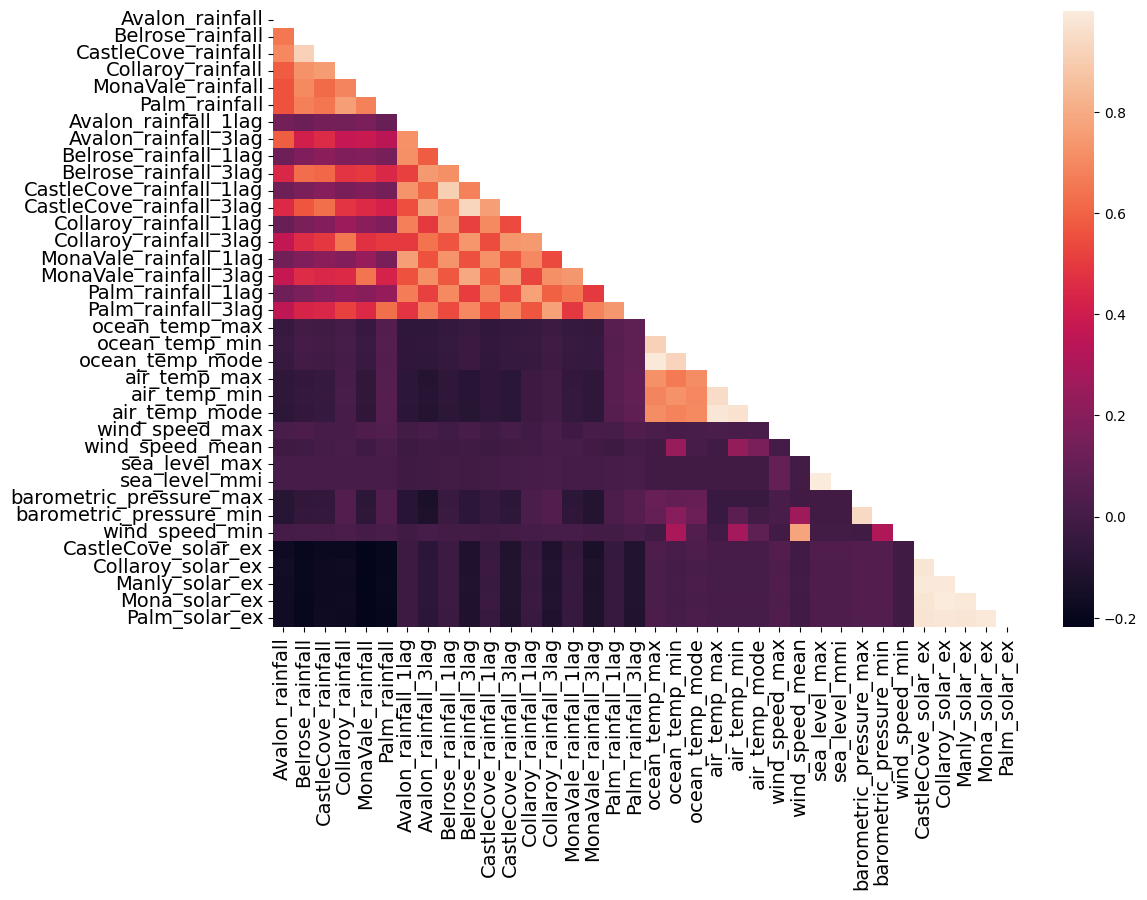

In [59]:
import matplotlib.pyplot as plt

mean_corr = df_master_naless.iloc[:,5:63].corr()

# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(12,8))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(mean_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(mean_corr, mask=mask, ax=ax)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)

# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

In [60]:
#write out dataset

df_master_naless.to_csv('df_master_naless.csv')

Modelling

In [61]:
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.linear_model  import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

In [62]:
#create some dummies based on iterative modeling. 
df_master_naless = df_master_naless.join(pd.get_dummies(df_master_naless['Site'], drop_first= True))
df_master_naless = df_master_naless.join(pd.get_dummies(df_master_naless['WindDirection_cat'], drop_first= True))



In [63]:
df_master_naless.drop(columns = 'WindDirection_cat', inplace = True)

In [64]:
# Create X and y.
X = df_master_naless.iloc[0:33556,5:74]
y = np.log(df_master_naless.cfu_per_100ml_Enterococci + 1)
#y = df_master_naless.cfu_per_100ml_Enterococci

In [65]:
lr = LinearRegression()

In [66]:
lr.fit(X,y)

LinearRegression()

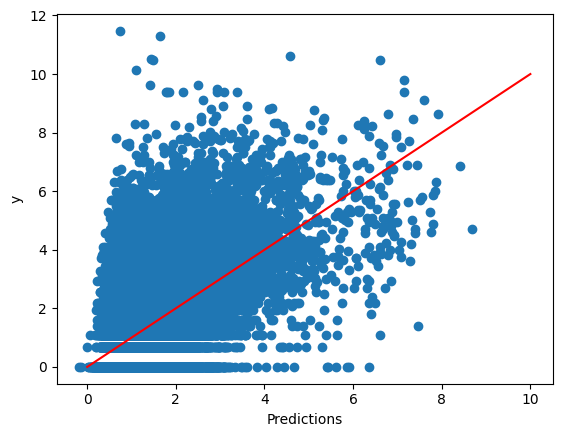

In [67]:
plt.scatter(lr.predict(X), y)
plt.plot([0, 10], [0, 10], c='red')
plt.ylabel('y')
plt.xlabel('Predictions')
plt.title('');

In [68]:
lr.score(X,y)

0.3037724085418404

We can see from the actuals vs predicted plots the predictions (log-transformed) are poor. We get an R-squared of .3, hence the linear model is only explaining about 30% of the variance. 

## Random Forest

In [69]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

In [70]:
rfreg = RandomForestRegressor(n_estimators=500, max_features=25, min_samples_leaf=2, oob_score=True, random_state=1)
rfreg.fit(X, y)
#pd.DataFrame({'feature':X, 'importance':rfreg.feature_importances_}).sort_values(by='importance')

#note I played around with various hyper-parameters to improve the fit of the model. 

RandomForestRegressor(max_features=25, min_samples_leaf=2, n_estimators=500,
                      oob_score=True, random_state=1)

In [71]:
# Compute the out-of-bag R-squared score.
print((rfreg.oob_score_))

# Find the average RMSE.
#scores = cross_val_score(rfreg, X, y, cv=10, scoring='neg_mean_squared_error')
#np.mean(np.sqrt(-scores))

0.48464328452086824


We get an out of bag r squared of 

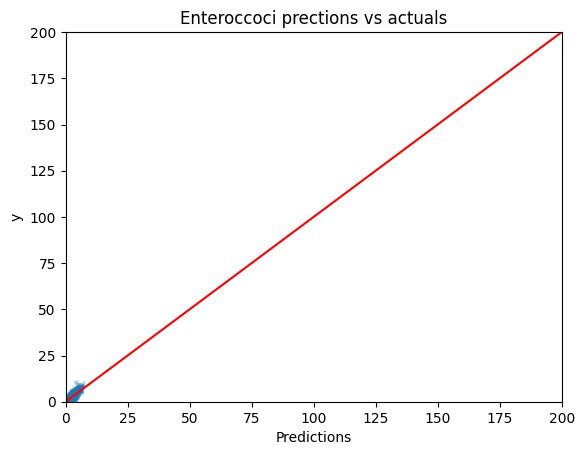

In [72]:
plt.scatter(rfreg.predict(X), y, [2], alpha=0.1)
plt.plot([0, 100000], [0, 100000], c='red')
plt.ylabel('y')
plt.xlabel('Predictions')
plt.title('Enteroccoci prections vs actuals')
plt.axis([0, 200, 0, 200]);

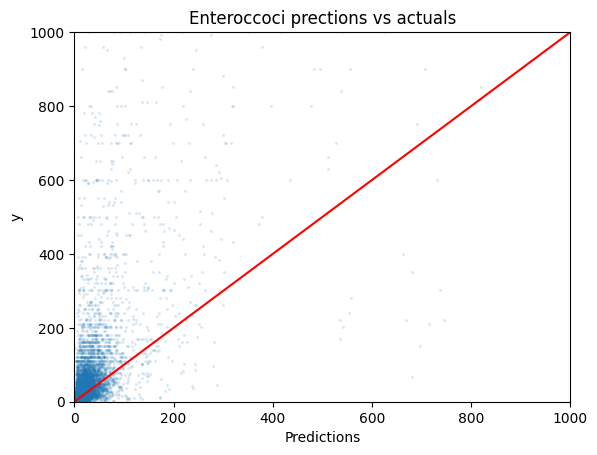

In [73]:
plt.scatter(np.exp(rfreg.predict(X)), np.exp(y), [2], alpha=0.1)
plt.plot([0, 100000], [0, 100000], c='red')
plt.ylabel('y')
plt.xlabel('Predictions')
plt.title('Enteroccoci prections vs actuals')
plt.axis([0, 1000, 0, 1000]);